In [1]:
import yaml
import umap

import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from math import floor
from scipy.stats import mannwhitneyu

from carot.utils import get_source_target_transport, score_transports_and_targets_combinations
from cmonge.utils import load_config
from carot.trainers.conditional_monge_trainer import ConditionalMongeTrainer
from carot.datasets.conditional_loader import ConditionalDataModule

/Users/alicedriessen/.virtualenvs/carot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sns.set(font="Arial")
sns.set_context("paper")
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.bottom'] = True

In [3]:
default_colors = {
    "indigo": "#332288",
    "cyan": "#88CCEE",
    "teal": "#44AA99",
    "green": "#117733",
    "olive": "#999933",
    "sand": "#DDCC77",
    "rose": "#CC6677",
    "wine": "#882255",
    "purple": "#AA4499",
    "grey": "#DDDDDD",
}

eval_setting_map = {
    "identity": default_colors["wine"],
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["indigo"],
    "within condition": default_colors["green"],
    "CAROT-oneCAR": default_colors["cyan"],
    "conCAROT-allCARs": default_colors["indigo"],
    "conCAROT-OOD-allCARs": default_colors["purple"],
    "conCAROT-selCARs": default_colors["teal"],
    "conCAROT-OOD-selCARs": default_colors["green"],
}

geneset_map = {
    "functional": default_colors["olive"],
    "functional+score": default_colors["rose"],
    "HVG": default_colors["teal"],
    "random": default_colors["sand"],
}

subset_map = {
    "CD4": default_colors["teal"],
    "CD8": default_colors["purple"],
}

ot_map = {
    "source": default_colors["cyan"],
    "target": default_colors["sand"],
    "transport": default_colors["rose"],
    "rest": default_colors["grey"]
}

cond_ood_comp = {
    "CAROT": default_colors["cyan"],
    "conCAROT": default_colors["indigo"],
    "conCAROT-OOD": default_colors["teal"],
}

In [4]:
features = "/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/functional_and_score_genes.txt"
base_fig_save = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Figures/"


# sel CARs OOD (conCAROT-OOD)

In [5]:
logger_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge_ood/sel_CARs_ood/"
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    for setting in ["identity", "cmonge", "within condition"]:
        with open(f"{logger_path}model_sel_cars_{subset}_{setting}_small_CARs_eval.yaml",) as stream:
            logs = yaml.safe_load(stream)
            
        for i in range(len(logs["experiments"])):
            for condition, results in logs["experiments"][i]["valid-set"].items():
                res = pd.Series(results["mean_statistics"])
                res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                res["eval_car"] = condition
                res["eval_setting"] = setting
                res["subset"] = subset
                all_mean_metrics.append(res)

In [6]:
sel_cars_ood_res = pd.concat(all_mean_metrics).reset_index(drop=True)
sel_cars_ood_res = sel_cars_ood_res[~sel_cars_ood_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
sel_cars_ood_res["eval_setting"] = ["conCAROT-OOD" if "cmonge" in s else s for s in sel_cars_ood_res["eval_setting"]]
sel_cars_ood_res["data_setting"] = "selCARs"
sel_cars_ood_res["ID_OOD"] = "OOD"

# sel CARs ID (conCAROT)

In [7]:
logger_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/cmonge/sel_CARs_LN_True_grad_acc_4_cosine/"
settings = ["conCAROT", "identity"] + ["within condition"]*32
all_mean_metrics=[]
for subset in ["CD4", "CD8"]:
    with open(f"{logger_path}{subset}_esm_XL_tail_dim_FuncScore/logs.yaml",) as stream:
        logs = yaml.safe_load(stream)
        
    for i in range(len(logs["experiments"])):
        for condition, results in logs["experiments"][i]["valid-set"].items():
            res = pd.Series(results["mean_statistics"])
            res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
            res["eval_car"] = condition
            res["eval_setting"] = settings[i]
            res["subset"] = subset
            all_mean_metrics.append(res)

In [8]:
sel_cars_id_res = pd.concat(all_mean_metrics).reset_index(drop=True)
sel_cars_id_res = sel_cars_id_res[~sel_cars_id_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
sel_cars_id_res["data_setting"] = "selCARs"
sel_cars_id_res["ID_OOD"] = "ID"

In [9]:
sel_cars_id_res

,metric,score,eval_car,eval_setting,subset,data_setting,ID_OOD
0,mean_wasserstein,5.533756,CD28-IL15RA-z,conCAROT,CD4,selCARs,ID
1,mean_mmd,0.026047,CD28-IL15RA-z,conCAROT,CD4,selCARs,ID
2,mean_sinkhorn div,5.047623,CD28-IL15RA-z,conCAROT,CD4,selCARs,ID
3,mean_monge_gap,11.387654,CD28-IL15RA-z,conCAROT,CD4,selCARs,ID
4,mean_drug_signature,0.756655,CD28-IL15RA-z,conCAROT,CD4,selCARs,ID
...,...,...,...,...,...,...,...
535,mean_mmd,0.014717,41BB-41BB-z,within condition,CD8,selCARs,ID
536,mean_sinkhorn div,5.485166,41BB-41BB-z,within condition,CD8,selCARs,ID
537,mean_monge_gap,12.362149,41BB-41BB-z,within condition,CD8,selCARs,ID
538,mean_drug_signature,0.886871,41BB-41BB-z,within condition,CD8,selCARs,ID


# conCAROT ID - all CARs

In [10]:
exp_order = ["conCAROT", "identity"] + ["within condition"]*32
exp_path = "/Users/alicedriessen/Library/CloudStorage/Box-Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/conditional-monge/experiments/"
all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    with open(f"{exp_path}cmonge/LN_True_grad_acc_4_cosine/{subset}_esm_XL_tail_dim_FuncScore/logs.yaml") as stream:
        logs = yaml.safe_load(stream)
    if len(logs["experiments"])==68:
        print("using only the first 34 logs")
        logs["experiments"]=logs["experiments"][:34]
    print(subset, len(logs["experiments"]))
    
    for i in range(len(logs["experiments"])):
        eval_setting = exp_order[i]
        for condition, results in logs["experiments"][i]["valid-set"].items():
            res = pd.Series(results["mean_statistics"])
            res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
            res["eval_car"] = condition
            res["eval_setting"] = eval_setting
            res["subset"] = subset
            all_mean_metrics.append(res)

CD4 34
CD8 34


In [11]:
all_cars_id_res = pd.concat(all_mean_metrics).reset_index(drop=True)
all_cars_id_res = all_cars_id_res[~all_cars_id_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
all_cars_id_res["data_setting"] = "allCARs"
all_cars_id_res["ID_OOD"] = "ID"

# conCAROT OOD - all CARs

In [12]:
with open("/Users/alicedriessen/Box/LegacyFromOldColleagues/Alice/CAR_Tcells/Model/OT/CAR_variants.txt", "r") as f:
    cars = f.read().splitlines()

base_exp_dir = f"{exp_path}cmonge_ood/LN_True_grad_acc_4_cosine/"
experiment_order = ["homogeneous", "conCAROT-OOD", "identity", "within condition"]

In [13]:
all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for car in cars:
        if car in ["NA-NA-z", "NA-NA-NA"]:
            continue
        else:
            with open(f"{base_exp_dir}{subset}_esm_XL_tail_dim_FuncScore/NA-NA-NA_{car}/logs.yaml") as stream:
                logs = yaml.safe_load(stream)
            if len(logs["experiments"])==68:
                print("using only the first 34 logs")
                logs["experiments"]=logs["experiments"][:34]
            print(subset, car, len(logs["experiments"]))
            
            for i in range(len(logs["experiments"])):
                eval_setting = experiment_order[i]
                for condition, results in logs["experiments"][i]["valid-set"].items():
                    res = pd.Series(results["mean_statistics"])
                    res = res.reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
                    res["eval_car"] = condition
                    res["eval_setting"] = eval_setting
                    res["subset"] = subset
                    all_mean_metrics.append(res)

CD4 41BB-41BB-z 4
CD4 41BB-CD28-z 4
CD4 41BB-CD40-z 4
CD4 41BB-CTLA4-z 4
CD4 41BB-IL15RA-z 4
CD4 41BB-NA-z 4
CD4 CD28-41BB-z 4
CD4 CD28-CD28-z 4
CD4 CD28-CD40-z 4
CD4 CD28-CTLA4-z 4
CD4 CD28-IL15RA-z 4
CD4 CD28-NA-z 4
CD4 CD40-41BB-z 4
CD4 CD40-CD28-z 4
CD4 CD40-CD40-z 4
CD4 CD40-CTLA4-z 4
CD4 CD40-IL15RA-z 4
CD4 CD40-NA-z 4
CD4 CTLA4-41BB-z 4
CD4 CTLA4-CD28-z 4
CD4 CTLA4-CD40-z 4
CD4 CTLA4-CTLA4-z 4
CD4 CTLA4-IL15RA-z 4
CD4 CTLA4-NA-z 4
CD4 IL15RA-41BB-z 4
CD4 IL15RA-CD28-z 4
CD4 IL15RA-CD40-z 4
CD4 IL15RA-CTLA4-z 4
CD4 IL15RA-IL15RA-z 4
CD4 IL15RA-NA-z 4
CD8 41BB-41BB-z 4
CD8 41BB-CD28-z 4
CD8 41BB-CD40-z 4
CD8 41BB-CTLA4-z 4
CD8 41BB-IL15RA-z 4
CD8 41BB-NA-z 4
CD8 CD28-41BB-z 4
CD8 CD28-CD28-z 4
CD8 CD28-CD40-z 4
CD8 CD28-CTLA4-z 4
CD8 CD28-IL15RA-z 4
CD8 CD28-NA-z 4
CD8 CD40-41BB-z 4
CD8 CD40-CD28-z 4
CD8 CD40-CD40-z 4
CD8 CD40-CTLA4-z 4
CD8 CD40-IL15RA-z 4
CD8 CD40-NA-z 4
CD8 CTLA4-41BB-z 4
CD8 CTLA4-CD28-z 4
CD8 CTLA4-CD40-z 4
CD8 CTLA4-CTLA4-z 4
CD8 CTLA4-IL15RA-z 4
CD8 CTLA4-NA

In [14]:
all_cars_ood_res = pd.concat(all_mean_metrics).reset_index(drop=True)
all_cars_ood_res = all_cars_ood_res[~all_cars_ood_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
all_cars_ood_res["data_setting"] = "allCARs"
all_cars_ood_res["ID_OOD"] = "OOD"
all_cars_ood_res

,metric,score,eval_car,eval_setting,subset,data_setting,ID_OOD
0,mean_wasserstein,5.655046,41BB-CD28-z,homogeneous,CD4,allCARs,OOD
1,mean_mmd,0.026761,41BB-CD28-z,homogeneous,CD4,allCARs,OOD
2,mean_sinkhorn div,5.171777,41BB-CD28-z,homogeneous,CD4,allCARs,OOD
3,mean_monge_gap,11.388451,41BB-CD28-z,homogeneous,CD4,allCARs,OOD
4,mean_drug_signature,0.942221,41BB-CD28-z,homogeneous,CD4,allCARs,OOD
...,...,...,...,...,...,...,...
12235,mean_mmd,0.012517,IL15RA-NA-z,within condition,CD8,allCARs,OOD
12236,mean_sinkhorn div,5.679140,IL15RA-NA-z,within condition,CD8,allCARs,OOD
12237,mean_monge_gap,12.339099,IL15RA-NA-z,within condition,CD8,allCARs,OOD
12238,mean_drug_signature,0.805206,IL15RA-NA-z,within condition,CD8,allCARs,OOD


# CAROT

In [15]:
base_log_dir = f"{exp_path}monge/FuncScore/logs/"
experiment_order = ["CAROT", "identity", "within condition"]

In [16]:
all_mean_metrics = []
for subset in ["CD4", "CD8"]:
    for car in cars:
        if car in ["NA-NA-z", "NA-NA-NA"]:
            continue
        with open(f"{base_log_dir}{subset}__NA-NA-NA_{car}_logs.yaml") as stream:
            logs = yaml.safe_load(stream)
        print(subset, car, len(logs["experiments"]))
        for i, exp in enumerate(logs["experiments"]):
            mean_stats = pd.DataFrame.from_dict(logs["experiments"][i]["mean_statistics"], orient="index")
            mean_stats['eval_car'] = car
            mean_stats["eval_setting"] = experiment_order[i]
            mean_stats["subset"] = subset

            all_mean_metrics.append(mean_stats)

CD4 41BB-41BB-z 3
CD4 41BB-CD28-z 3
CD4 41BB-CD40-z 3
CD4 41BB-CTLA4-z 3
CD4 41BB-IL15RA-z 3
CD4 41BB-NA-z 3
CD4 CD28-41BB-z 3
CD4 CD28-CD28-z 3
CD4 CD28-CD40-z 3
CD4 CD28-CTLA4-z 3
CD4 CD28-IL15RA-z 3
CD4 CD28-NA-z 3
CD4 CD40-41BB-z 3
CD4 CD40-CD28-z 3
CD4 CD40-CD40-z 3
CD4 CD40-CTLA4-z 3
CD4 CD40-IL15RA-z 3
CD4 CD40-NA-z 3
CD4 CTLA4-41BB-z 3
CD4 CTLA4-CD28-z 3
CD4 CTLA4-CD40-z 3
CD4 CTLA4-CTLA4-z 3
CD4 CTLA4-IL15RA-z 3
CD4 CTLA4-NA-z 3
CD4 IL15RA-41BB-z 3
CD4 IL15RA-CD28-z 3
CD4 IL15RA-CD40-z 3
CD4 IL15RA-CTLA4-z 3
CD4 IL15RA-IL15RA-z 3
CD4 IL15RA-NA-z 3
CD8 41BB-41BB-z 3
CD8 41BB-CD28-z 3
CD8 41BB-CD40-z 3
CD8 41BB-CTLA4-z 3
CD8 41BB-IL15RA-z 3
CD8 41BB-NA-z 3
CD8 CD28-41BB-z 3
CD8 CD28-CD28-z 3
CD8 CD28-CD40-z 3
CD8 CD28-CTLA4-z 3
CD8 CD28-IL15RA-z 3
CD8 CD28-NA-z 3
CD8 CD40-41BB-z 3
CD8 CD40-CD28-z 3
CD8 CD40-CD40-z 3
CD8 CD40-CTLA4-z 3
CD8 CD40-IL15RA-z 3
CD8 CD40-NA-z 3
CD8 CTLA4-41BB-z 3
CD8 CTLA4-CD28-z 3
CD8 CTLA4-CD40-z 3
CD8 CTLA4-CTLA4-z 3
CD8 CTLA4-IL15RA-z 3
CD8 CTLA4-NA

In [17]:
carot_res = pd.concat(all_mean_metrics).reset_index(drop=False).rename(columns={"index": "metric", 0: "score"})
carot_res = carot_res[~carot_res["eval_car"].isin(["NA-NA-NA", "NA-NA-z"])]
carot_res["data_setting"] = "oneCAR"
carot_res["ID_OOD"] = "ID"
carot_res

,metric,score,eval_car,eval_setting,subset,data_setting,ID_OOD
0,mean_wasserstein,5.668510,41BB-41BB-z,CAROT,CD4,oneCAR,ID
1,mean_mmd,0.024757,41BB-41BB-z,CAROT,CD4,oneCAR,ID
2,mean_sinkhorn div,5.192612,41BB-41BB-z,CAROT,CD4,oneCAR,ID
3,mean_monge_gap,11.405769,41BB-41BB-z,CAROT,CD4,oneCAR,ID
4,mean_drug_signature,0.731012,41BB-41BB-z,CAROT,CD4,oneCAR,ID
...,...,...,...,...,...,...,...
1075,mean_mmd,0.012517,IL15RA-NA-z,within condition,CD8,oneCAR,ID
1076,mean_sinkhorn div,5.679140,IL15RA-NA-z,within condition,CD8,oneCAR,ID
1077,mean_monge_gap,12.339099,IL15RA-NA-z,within condition,CD8,oneCAR,ID
1078,mean_drug_signature,0.805206,IL15RA-NA-z,within condition,CD8,oneCAR,ID


# Concat and plot results

In [18]:
res = pd.concat([all_cars_id_res, all_cars_ood_res, sel_cars_id_res, sel_cars_ood_res, carot_res])
con_carot_res = res[~res["eval_setting"].isin(["identity", "homogeneous", "within condition"])]
con_carot_res["model"] = con_carot_res["eval_setting"] + "-" + con_carot_res["data_setting"]

/var/folders/02/gztwz1tj1051mtt_ykv6v7940000gn/T/ipykernel_72507/438210343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  con_carot_res["model"] = con_carot_res["eval_setting"] + "-" + con_carot_res["data_setting"]


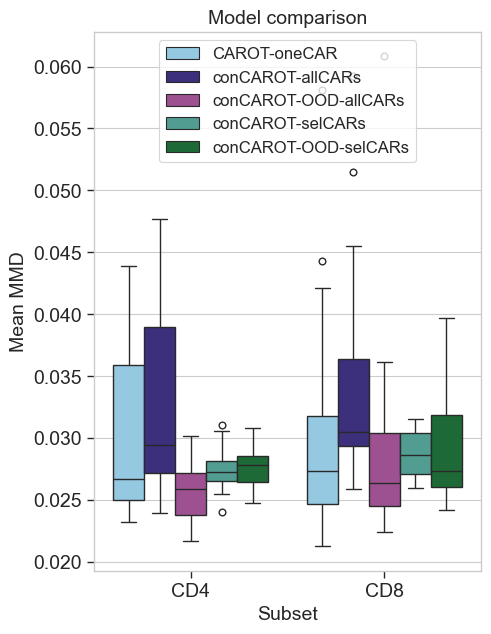

In [19]:
plt_data = con_carot_res[(con_carot_res["metric"]=='mean_mmd')]

plt.figure(figsize=(5,7))
sns.boxplot(plt_data, x="subset", y="score", hue="model", palette=eval_setting_map, hue_order=["CAROT-oneCAR", 
                                                                                               "conCAROT-allCARs",
                                                                                               "conCAROT-OOD-allCARs",
                                                                                               "conCAROT-selCARs",
                                                                                               "conCAROT-OOD-selCARs"
                                                ])
plt.title("Model comparison", fontsize=14)
plt.xlabel("Subset", fontsize=14)
plt.ylabel("Mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(fontsize=12, loc="upper center")
plt.savefig(f"{base_fig_save}CAROTs_comparison_MMD.pdf", bbox_inches="tight")

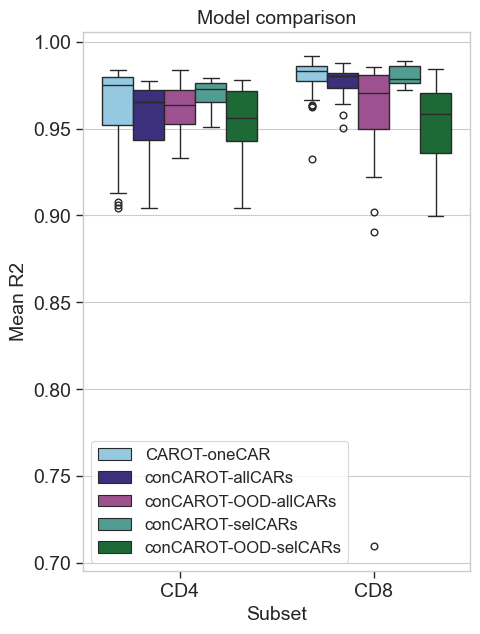

In [20]:
plt_data = con_carot_res[(con_carot_res["metric"]=='mean_r2')]

plt.figure(figsize=(5,7))
sns.boxplot(plt_data, x="subset", y="score", hue="model", palette=eval_setting_map, hue_order=["CAROT-oneCAR", 
                                                                                               "conCAROT-allCARs",
                                                                                               "conCAROT-OOD-allCARs",
                                                                                               "conCAROT-selCARs",
                                                                                               "conCAROT-OOD-selCARs"
                                                                                            ])
plt.title("Model comparison", fontsize=14)
plt.xlabel("Subset", fontsize=14)
plt.ylabel("Mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(fontsize=12, loc="lower left")
plt.savefig(f"{base_fig_save}CAROTs_comparison_R2.pdf", bbox_inches="tight")

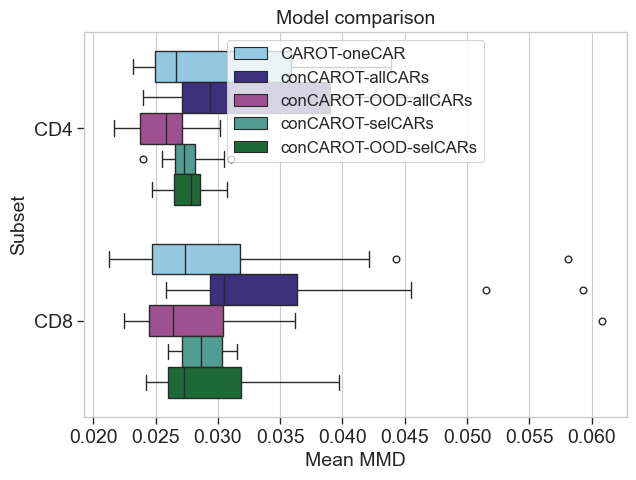

In [21]:
plt_data = con_carot_res[(con_carot_res["metric"]=='mean_mmd')]

plt.figure(figsize=(7,5))
sns.boxplot(plt_data, y="subset", x="score", hue="model", palette=eval_setting_map, hue_order=["CAROT-oneCAR", 
                                                                                               "conCAROT-allCARs",
                                                                                               "conCAROT-OOD-allCARs",
                                                                                               "conCAROT-selCARs",
                                                                                               "conCAROT-OOD-selCARs"
                                                ])
plt.title("Model comparison", fontsize=14)
plt.ylabel("Subset", fontsize=14)
plt.xlabel("Mean MMD", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(fontsize=12, loc="upper center")
plt.savefig(f"{base_fig_save}CAROTs_comparison_MMD_horizontal.pdf", bbox_inches="tight")

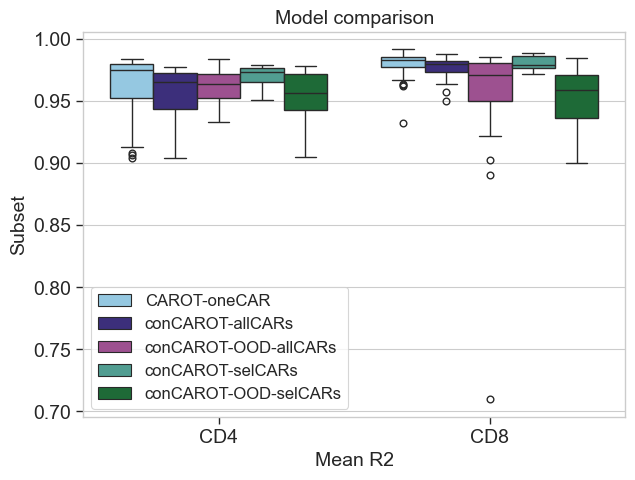

In [22]:
plt_data = con_carot_res[(con_carot_res["metric"]=='mean_r2')]

plt.figure(figsize=(7,5))
sns.boxplot(plt_data, x="subset", y="score", hue="model", palette=eval_setting_map, hue_order=["CAROT-oneCAR", 
                                                                                               "conCAROT-allCARs",
                                                                                               "conCAROT-OOD-allCARs",
                                                                                               "conCAROT-selCARs",
                                                                                               "conCAROT-OOD-selCARs"
                                                                                            ])
plt.title("Model comparison", fontsize=14)
plt.ylabel("Subset", fontsize=14)
plt.xlabel("Mean R2", fontsize=14)
plt.tick_params(which="both", axis="both", labelsize=14)
plt.legend(fontsize=12, loc="lower left")
plt.savefig(f"{base_fig_save}CAROTs_comparison_R2.pdf", bbox_inches="tight")

## Per subset, both scores

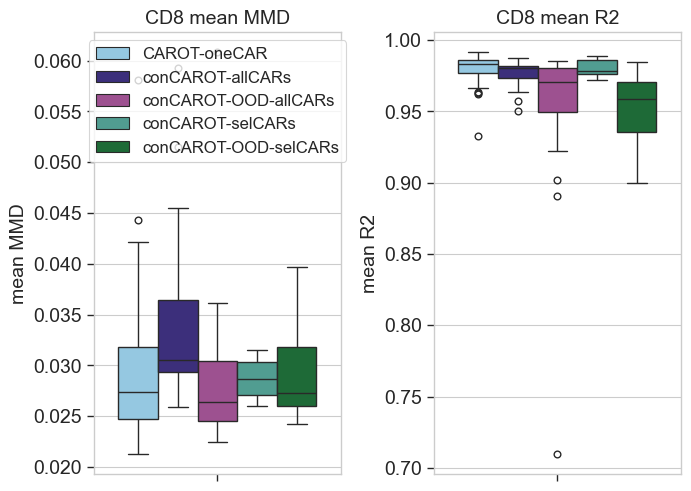

In [23]:
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(7,5))
for i, score in enumerate(["mean_mmd", "mean_r2"]):
    plt_data = con_carot_res[(con_carot_res["subset"]=="CD8")&(con_carot_res["metric"]==score)]
    sns.boxplot(data=plt_data, y="score", hue="model", ax=axes[i], palette=eval_setting_map,
               hue_order=["CAROT-oneCAR",
                          "conCAROT-allCARs", "conCAROT-OOD-allCARs",
                          "conCAROT-selCARs", "conCAROT-OOD-selCARs" ])
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].set_title("CD8 mean MMD", fontsize=14)
axes[0].set_ylabel("mean MMD", fontsize=14)
axes[1].set_title("CD8 mean R2", fontsize=14)
axes[1].set_ylabel("mean R2", fontsize=14)
axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.tight_layout()
plt.savefig(f"{base_fig_save}CAROTs_comparison_CD8.pdf", bbox_inches="tight")

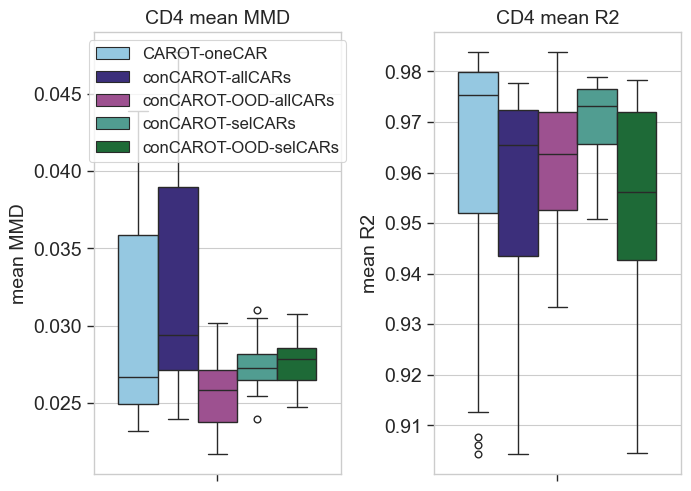

In [24]:
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(7,5))
for i, score in enumerate(["mean_mmd", "mean_r2"]):
    plt_data = con_carot_res[(con_carot_res["subset"]=="CD4")&(con_carot_res["metric"]==score)]
    sns.boxplot(data=plt_data, y="score", hue="model", ax=axes[i], palette=eval_setting_map,
               hue_order=["CAROT-oneCAR",
                          "conCAROT-allCARs", "conCAROT-OOD-allCARs",
                          "conCAROT-selCARs", "conCAROT-OOD-selCARs" ])
    axes[i].tick_params(which="both", axis="both", labelsize=14)

axes[0].set_title("CD4 mean MMD", fontsize=14)
axes[0].set_ylabel("mean MMD", fontsize=14)
axes[1].set_title("CD4 mean R2", fontsize=14)
axes[1].set_ylabel("mean R2", fontsize=14)
axes[1].get_legend().remove()
axes[0].legend(fontsize=12, loc="upper center")
plt.tight_layout()
plt.savefig(f"{base_fig_save}CAROTs_comparison_CD4.pdf", bbox_inches="tight")

In [25]:
sel_cars_id_res.loc[sel_cars_id_res["subset"]=="CD8", "eval_car"].unique()

array(['IL15RA-CD40-z', 'CD40-CD40-z', 'CD40-NA-z', 'IL15RA-41BB-z',
       'IL15RA-CTLA4-z', 'IL15RA-NA-z', 'CD28-NA-z', '41BB-IL15RA-z',
       '41BB-NA-z', 'CD40-CD28-z', 'CD28-IL15RA-z', 'CD28-CD28-z',
       'IL15RA-CD28-z', '41BB-41BB-z'], dtype=object)

In [30]:
con_carot_res.groupby(["data_setting", "model", "subset", "metric"]).median(numeric_only=True).reset_index()

,data_setting,model,subset,metric,score
0,allCARs,conCAROT-OOD-allCARs,CD4,mean_drug_signature,0.945333
1,allCARs,conCAROT-OOD-allCARs,CD4,mean_mmd,0.025869
2,allCARs,conCAROT-OOD-allCARs,CD4,mean_monge_gap,11.416728
3,allCARs,conCAROT-OOD-allCARs,CD4,mean_r2,0.963668
4,allCARs,conCAROT-OOD-allCARs,CD4,mean_sinkhorn div,4.982564
5,allCARs,conCAROT-OOD-allCARs,CD4,mean_wasserstein,5.497613
6,allCARs,conCAROT-OOD-allCARs,CD8,mean_drug_signature,1.142130
7,allCARs,conCAROT-OOD-allCARs,CD8,mean_mmd,0.026381
8,allCARs,conCAROT-OOD-allCARs,CD8,mean_monge_gap,11.846553
9,allCARs,conCAROT-OOD-allCARs,CD8,mean_r2,0.970592
